In [32]:
!pip install spark 
!pip install findspark 
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#import Libraries

In [33]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import pyspark.sql.types as tp
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row, SQLContext
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
import matplotlib.pyplot as plt

#Read Data

In [34]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/amazon.csv')    
print(type(df))

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<class 'pyspark.sql.dataframe.DataFrame'>


In [35]:
df.printSchema()

root
 |-- url: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- review_title: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- review_rating: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- helpful_count: string (nullable = true)
 |-- uniq_id: string (nullable = true)
 |-- scraped_at: string (nullable = true)



In [36]:
df.count()

6844

#preprocessing

In [37]:
#drop null values at review_text and review_rating
df = df.filter(df.review_text.isNotNull()).drop()
df = df.filter(df.review_rating.isNotNull()).drop()

In [38]:
df.count()

6807

In [39]:
df.show()

+--------------------+--------------------+----------------+----------------------+---------------------------------+-------------+-----------------+--------------------+--------------------+--------------------+-------------------+
|                 url|        product_name|   reviewer_name|          review_title|                      review_text|review_rating|verified_purchase|         review_date|       helpful_count|             uniq_id|         scraped_at|
+--------------------+--------------------+----------------+----------------------+---------------------------------+-------------+-----------------+--------------------+--------------------+--------------------+-------------------+
|https://www.amazo...|Klasified Women's...|Jocelyn McSayles|               Love em|             Love these. Was l...|          5.0|             True|Reviewed in the U...|2 people found th...|36eae4e5-2894-527...|24/12/2021 02:26:25|
|https://www.amazo...|Klasified Women's...|    Kenia Rivera|    The 

In [40]:
#drop duplicated raws
df = df.dropDuplicates()

In [41]:
#select feature and label
df=df.select("review_text","review_rating")

In [42]:
df.show()

+--------------------+--------------------+
|         review_text|       review_rating|
+--------------------+--------------------+
|True to size. If ...|                 5.0|
|Comfortable fit e...|                 3.0|
|Die besten Sommer...|                 5.0|
|Article encore pl...|                 5.0|
|Very comfortable ...|                 5.0|
|The product is no...|                 1.0|
|I got a size 6 bi...|                 4.0|
|El mejor par de r...|                 5.0|
|I ordered these a...|                 5.0|
|belles et confort...|                 5.0|
|My 11 year old da...|                 3.0|
|These were so cut...|                 3.0|
|Amazon you did it...|                 5.0|
|     They were great|                 5.0|
|I wish I had read...|                 4.0|
|So disappointed! ...|                 3.0|
|I saw a few quest...|                 5.0|
|"These are super ...| maybe even a 5. ...|
|La talla no es la...|                 5.0|
|My daughter was r...|          

In [43]:
#order the data ascending according to review_rating
df = df.orderBy(df.review_rating.asc())

In [44]:
#removing noisy data at review_rating
df = df[(df.review_rating == 1) | (df.review_rating == 2) | (df.review_rating == 3) | (df.review_rating == 4) | (df.review_rating == 5)]

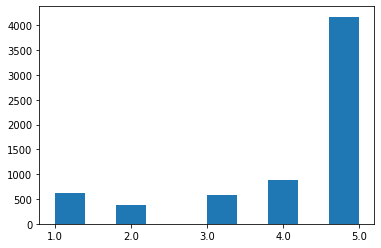

In [45]:
#plot review_rating 
plt.hist(df.toPandas()['review_rating'])
plt.show()

In [46]:
df.show(10)

+--------------------+-------------+
|         review_text|review_rating|
+--------------------+-------------+
|It runs smaller, ...|          1.0|
|Poor quality tip ...|          1.0|
|Soy muy fan de la...|          1.0|
|The product is no...|          1.0|
|Los devolví cuand...|          1.0|
|Despues de 2 días...|          1.0|
|         Way too big|          1.0|
|I’ve had sketcher...|          1.0|
|The shoes are too...|          1.0|
|Bei diesen Schuhe...|          1.0|
+--------------------+-------------+
only showing top 10 rows



In [47]:
#encoded the review data into zeros and ones 
#zero indicates to negative 
#one indicates to neutral
#two indicates to positive
df =df.select('review_text','review_rating').replace(['1.0','2.0','3.0','4.0', '5.0'],['0.0','0.0','1.0','2.0', '2.0'])

In [48]:
df.show()

+--------------------+-------------+
|         review_text|review_rating|
+--------------------+-------------+
|I’m a huge mizuno...|          0.0|
|The shoes are too...|          0.0|
|para ser de la ma...|          0.0|
|Damaged products ...|          0.0|
|Bei diesen Schuhe...|          0.0|
|I have worn New B...|          0.0|
|Despues de 2 días...|          0.0|
|Nett, aber nach e...|          0.0|
|I’ve had sketcher...|          0.0|
|Dieser Schuh hat ...|          0.0|
|We were moving an...|          0.0|
|Very pretty in ap...|          0.0|
|Soy muy fan de la...|          0.0|
|Poor quality tip ...|          0.0|
|         Way too big|          0.0|
|Bonjour,je suis t...|          0.0|
|Omg. They look go...|          0.0|
|I wear Men's 8.5 ...|          0.0|
|I ordered this in...|          0.0|
|These are the wor...|          0.0|
+--------------------+-------------+
only showing top 20 rows



In [49]:
#casting the review rating data from string to integer
df = df.withColumn("review_rating",df.review_rating.cast('int'))

In [50]:
df.show()

+--------------------+-------------+
|         review_text|review_rating|
+--------------------+-------------+
|I’m a huge mizuno...|            0|
|The shoes are too...|            0|
|para ser de la ma...|            0|
|Damaged products ...|            0|
|Bei diesen Schuhe...|            0|
|I have worn New B...|            0|
|Despues de 2 días...|            0|
|Nett, aber nach e...|            0|
|I’ve had sketcher...|            0|
|Dieser Schuh hat ...|            0|
|We were moving an...|            0|
|Very pretty in ap...|            0|
|Soy muy fan de la...|            0|
|Poor quality tip ...|            0|
|         Way too big|            0|
|Bonjour,je suis t...|            0|
|Omg. They look go...|            0|
|I wear Men's 8.5 ...|            0|
|I ordered this in...|            0|
|These are the wor...|            0|
+--------------------+-------------+
only showing top 20 rows



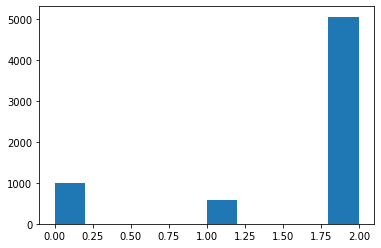

In [51]:
#plot the data
plt.hist(df.toPandas()['review_rating'])
plt.show()

#Build Model

In [52]:
#split data into train and test
(trainData, testData) = df.randomSplit([0.7, 0.3], seed = 100)

In [53]:
#define stage 1: tokenize the tweet text    
stage_1 = RegexTokenizer(inputCol= 'review_text' , outputCol= 'tokens', pattern= '\\W')
#define stage 2: remove the stop words
stage_2 = StopWordsRemover(inputCol= 'tokens', outputCol= 'filtered_words')
#define stage 3: create a word vector of the size 100
stage_3 = Word2Vec(inputCol= 'filtered_words', outputCol= 'vector', vectorSize= 100)
#define stage 4: Logistic Regression Model
model = LogisticRegression(featuresCol= 'vector', labelCol= 'review_rating')

In [54]:
#setup the pipeline
pipeline = Pipeline(stages= [stage_1, stage_2, stage_3, model])

#fit the pipeline model with the training data
pipeline_model = pipeline.fit(trainData)

#evaluate model

In [55]:
train_evaluate =  pipeline_model.transform(trainData)

In [56]:
#measure the train metrics
train_accuracy = MulticlassClassificationEvaluator(labelCol="review_rating", predictionCol="prediction", metricName="accuracy")
train_precision = MulticlassClassificationEvaluator(labelCol="review_rating", predictionCol="prediction", metricName="weightedPrecision")
train_recall = MulticlassClassificationEvaluator(labelCol="review_rating", predictionCol="prediction", metricName="weightedRecall")
train_f1 = MulticlassClassificationEvaluator(labelCol="review_rating", predictionCol="prediction", metricName="f1")

accuracy = train_accuracy.evaluate(train_evaluate)
precision = train_precision.evaluate(train_evaluate)
recall = train_recall.evaluate(train_evaluate)
f1score = train_f1.evaluate(train_evaluate)

print('accuracy: %0.4f' % accuracy)
print('precision: %0.4f' % precision)
print('recall: %0.4f' % recall)
print('F1 score: %0.4f' % f1score)


accuracy: 0.7736
precision: 0.6987
recall: 0.7736
F1 score: 0.7079


<BarContainer object of 4 artists>

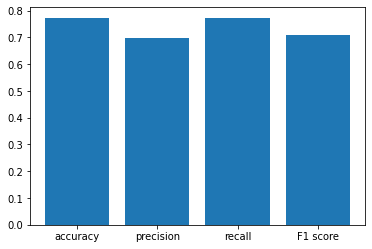

In [57]:
#plot train metrics
list_train = {'accuracy':accuracy,'precision':precision,'recall':recall,'F1 score':f1score}
x= list(list_train.keys())
y= list(list_train.values())
plt.bar(x,y)

In [58]:
test_evaluate =  pipeline_model.transform(testData)

In [59]:
#measure the test metrics
test_accuracy = MulticlassClassificationEvaluator(labelCol="review_rating", predictionCol="prediction", metricName="accuracy")
test_precision = MulticlassClassificationEvaluator(labelCol="review_rating", predictionCol="prediction", metricName="weightedPrecision")
test_recall = MulticlassClassificationEvaluator(labelCol="review_rating", predictionCol="prediction", metricName="weightedRecall")
test_f1 = MulticlassClassificationEvaluator(labelCol="review_rating", predictionCol="prediction", metricName="f1")


accuracy = test_accuracy.evaluate(test_evaluate)
precision = test_precision.evaluate(test_evaluate)
recall = test_recall.evaluate(test_evaluate)
f1score = test_f1.evaluate(test_evaluate)

print('accuracy: %0.4f' % accuracy)
print('precision: %0.4f' % precision)
print('recall: %0.4f' % recall)
print('F1 score: %0.4f' % f1score)

accuracy: 0.7547
precision: 0.6498
recall: 0.7547
F1 score: 0.6808


<BarContainer object of 4 artists>

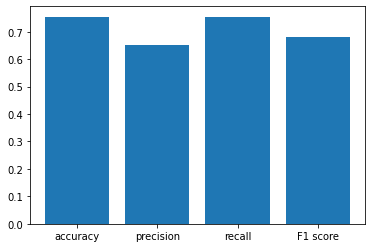

In [60]:
#plot test metrics
list_train = {'accuracy':accuracy,'precision':precision,'recall':recall,'F1 score':f1score}
x= list(list_train.keys())
y= list(list_train.values())
plt.bar(x,y)